# 风险管理作业4
-----
2501210025 叶云鹏

In [19]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings
import os
from scipy.stats import norm

warnings.filterwarnings('ignore')

# plt.rcParams['font.sans-serif'] = ['Hiragino Sans GB']  # 用来正常显示中文标签
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签

plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

## （一）.股票投资组合VaR计算

选取具有代表性的十只股票构成股票组合，要求十只股票属于不同的行业。收集这十只股票的历史数据，要求至少两年的数据。根据历史数据，估计日收益率的期望和方差，以及十只股票的日收益率的相关系数。根据这十只股票，设计投资组合，并计算该投资组合的边际VaR和成分VaR

In [20]:
# 第一步：根据原始数据计算日频对数收益率return_df
def get_data(comb_stock_codes):
    
    raw_data_list = []
    for r,d,fs in os.walk('../data/csmar_close'):
        for f in fs:
            if (not ('[DES]' in f)) and ('txt' in f):
                file_path = os.path.join(r,f)
                #print(file_path)
                raw_data_list.append(pd.read_csv(file_path,
                            sep='\t',
                            dtype={'Stkcd': str})[['Trddt','Stkcd','Adjprcwd']])
    working_data  =  pd.concat(raw_data_list,axis=0).set_index(['Trddt','Stkcd'])
    workding_df = working_data.unstack('Stkcd')
    df = workding_df.T.dropna().T
    df.columns = df.columns.get_level_values(1)

    return df[comb_stock_codes]

comb_stock_codes = ['000001','002330','000607','000021','600448',
                    '688233','000901','600722','900948','601208']

price_df = get_data(comb_stock_codes)
price_df.index = pd.to_datetime(price_df.index)
price_df
return_df = np.log(price_df.shift(-1)/price_df)


In [21]:
# 第二步：估计日收益率的期望、方差和相关系数
expected_returns = return_df.mean()
variances = return_df.var()
correlation_matrix = return_df.corr()
covariance_matrix = return_df.cov()  # 后续用于投资组合计算

print("\n日收益率期望：")
display(expected_returns.to_frame(name='期望收益率'))

print("\n日收益率方差：")
display(variances.to_frame(name='方差'))

print("\n日收益率相关系数矩阵：")
display(correlation_matrix)


日收益率期望：


,期望收益率
Stkcd,
000001,-0.000101
002330,-0.000288
000607,0.000049
000021,0.000252
600448,-0.000132
688233,0.000080
000901,0.000349
600722,0.000411
900948,0.001199



日收益率方差：


,方差
Stkcd,
000001,0.000336
002330,0.000647
000607,0.000870
000021,0.000755
600448,0.000650
688233,0.001474
000901,0.000637
600722,0.000898
900948,0.000441



日收益率相关系数矩阵：


Stkcd,000001,002330,000607,000021,600448,688233,000901,600722,900948,601208
Stkcd,,,,,,,,,,
000001,1.000000,0.189848,0.136566,0.140570,0.113534,0.067478,0.137355,0.190699,0.221797,0.125790
002330,0.189848,1.000000,0.378947,0.244086,0.371026,0.214227,0.287330,0.288838,0.151713,0.207565
000607,0.136566,0.378947,1.000000,0.323114,0.386023,0.278561,0.335369,0.284906,0.133918,0.210792
000021,0.140570,0.244086,0.323114,1.000000,0.211220,0.490969,0.411897,0.213016,0.125993,0.379280
600448,0.113534,0.371026,0.386023,0.211220,1.000000,0.249660,0.256545,0.333190,0.154253,0.202154
688233,0.067478,0.214227,0.278561,0.490969,0.249660,1.000000,0.357354,0.228089,0.083645,0.382659
000901,0.137355,0.287330,0.335369,0.411897,0.256545,0.357354,1.000000,0.327389,0.196895,0.357760
600722,0.190699,0.288838,0.284906,0.213016,0.333190,0.228089,0.327389,1.000000,0.270858,0.223439
900948,0.221797,0.151713,0.133918,0.125993,0.154253,0.083645,0.196895,0.270858,1.000000,0.176979


(a)若假设X_t服从正态，记上述方差协方差矩阵为$\Sigma$,均值$\mu$,联合分布为$N(\mu,\Sigma)$

(b) 给出组合 $b = (1/10，1/10，1/10，...,1/10)^{'}$
由
则$W_t \sim N(-V_tb^{'}\mu,{V_t}^2b^{'}\Sigma b)$


In [22]:
# 第三步：设计投资组合
# 简单起见，假设等权重投资组合（每只股票权重 10%）

In [23]:
weights = np.array([0.1] * 10)
portfolio_df = pd.DataFrame({
    '股票': return_df.columns,
    '权重': weights,
    '期望收益率': expected_returns,
    '方差': variances
})
print("\n投资组合设计（等权重）：")
display(portfolio_df)

# 计算投资组合期望收益率和标准差
portfolio_expected_return = np.dot(weights, expected_returns)
portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
portfolio_std = np.sqrt(portfolio_variance)

print(f"\n投资组合日期望收益率：{portfolio_expected_return:.6f}")
print(f"投资组合日方差：{portfolio_variance:.6f}")
print(f"投资组合日标准差：{portfolio_std:.6f}")


投资组合设计（等权重）：


,股票,权重,期望收益率,方差
Stkcd,,,,
000001,000001,0.1,-0.000101,0.000336
002330,002330,0.1,-0.000288,0.000647
000607,000607,0.1,0.000049,0.000870
000021,000021,0.1,0.000252,0.000755
600448,600448,0.1,-0.000132,0.000650
688233,688233,0.1,0.000080,0.001474
000901,000901,0.1,0.000349,0.000637
600722,600722,0.1,0.000411,0.000898
900948,900948,0.1,0.001199,0.000441



投资组合日期望收益率：0.000271
投资组合日方差：0.000245
投资组合日标准差：0.015639


In [24]:
# 第四步：计算投资组合 VaR（假设正态分布，95% 置信水平）
# VaR 表示在给定时间段内、特定置信水平下可能的最大损失
# 95% 日 VaR，使用 5% 尾部的 z 分数（单尾，负值表示损失）
confidence_level = 0.95
z = norm.ppf(0.05)  # ≈ -1.64485
# 参数 VaR 公式：VaR = mu_p + z * sigma_p（收益率阈值，低于此值的占 5%）
portfolio_var_threshold = portfolio_expected_return + z * portfolio_std
portfolio_var_loss = -portfolio_var_threshold  # 损失值（正值表示损失）

print(f"\n95% 日投资组合 VaR（收益率阈值）：{portfolio_var_threshold:.6f}（低于此收益率的概率为 5%）")
print(f"95% 日投资组合 VaR（损失值）：{portfolio_var_loss:.6f}（最差 5% 的预期最大损失）")


95% 日投资组合 VaR（收益率阈值）：-0.025454（低于此收益率的概率为 5%）
95% 日投资组合 VaR（损失值）：0.025454（最差 5% 的预期最大损失）


In [25]:
# 第五步：计算边际 VaR 和成分 VaR
# 边际 VaR (MVaR)：VaR 对资产权重的偏导数
# 正态假设下：MVaR_i = mu_i + z * (Cov * w)_i / sigma_p
marginal_var = expected_returns + z * (covariance_matrix @ weights) / portfolio_std
# 成分 VaR (CVaR)：权重 * 边际 VaR
component_var = weights * marginal_var
# 成分 VaR 之和应等于投资组合 VaR 阈值

var_df = pd.DataFrame({
    '股票': return_df.columns,
    '权重': weights,
    '边际 VaR': marginal_var,
    '成分 VaR': component_var
})
var_df.loc['总计', '成分 VaR'] = component_var.sum()

print("\n边际 VaR 和成分 VaR（针对 95% VaR 阈值）：")
display(var_df)

print(f"成分 VaR 总和：{component_var.sum():.6f}（应与投资组合 VaR 阈值一致：{portfolio_var_threshold:.6f}）")


边际 VaR 和成分 VaR（针对 95% VaR 阈值）：


,股票,权重,边际 VaR,成分 VaR
Stkcd,,,,
000001,000001,0.1,-0.010518,-0.001052
002330,002330,0.1,-0.024276,-0.002428
000607,000607,0.1,-0.030070,-0.003007
000021,000021,0.1,-0.028819,-0.002882
600448,600448,0.1,-0.024113,-0.002411
688233,688233,0.1,-0.041113,-0.004111
000901,000901,0.1,-0.026456,-0.002646
600722,600722,0.1,-0.028851,-0.002885
900948,900948,0.1,-0.012447,-0.001245


成分 VaR 总和：-0.025454（应与投资组合 VaR 阈值一致：-0.025454）


## （二）给定投资组合计算VaR
假设某投资组合由资产A和资产B构成，二者的收益率波动性分别为5%和12%。该投资组合分别投资200万资产A和100万元资产B。分别在二者收益率的相关系数为0.3.0,-0.3下，计算在95%水平下的组合的VaR，边际VaR和成分VaR。并分析相关系数假设对结果的影响

$$
\begin{aligned}
&\text{假设投资组合收益率服从正态分布，均值为0，95\%置信水平下标准化正态分位数 } z_{0.95} = 1.645\text{。} \\
&\text{资产A波动率 } \sigma_A \text{，资产B波动率 } \sigma_B \text{，投资额 } P_A, P_B \text{，总价值 } V = P_A + P_B \text{，} \\
&\text{权重 } w_A = \frac{P_A}{V} \text{，} w_B = \frac{P_B}{V} \text{，相关系数 } \rho \text{。定义如下：} \\
\\
&\text{\textbf{组合波动率}} \\
&\sigma_p^2 = w_A^2 \sigma_A^2 + w_B^2 \sigma_B^2 + 2 w_A w_B \rho \sigma_A \sigma_B \\
&\text{矩阵形式：} \\
&\sigma_p^2 = \begin{bmatrix} w_A & w_B \end{bmatrix}
\begin{bmatrix}
\sigma_A^2 & \rho \sigma_A \sigma_B \\
\rho \sigma_A \sigma_B & \sigma_B^2
\end{bmatrix}
\begin{bmatrix} w_A \\ w_B \end{bmatrix} \\
&\sigma_p = \sqrt{\sigma_p^2} \\
&\text{组合VaR：} \\
&\text{VaR} = z_{0.95} \cdot \sigma_p \cdot V \\
\\
&\text{\textbf{边际VaR}} \\
&\Delta \text{VaR}_i = z_{0.95} \cdot \frac{\text{Cov}(r_i, r_p)}{\sigma_p} \\
&\text{组合收益率 } r_p = w_A r_A + w_B r_B \text{，协方差计算：} \\
&\text{Cov}(r_A, r_p) = w_A \sigma_A^2 + w_B \rho \sigma_A \sigma_B \\
&\text{Cov}(r_B, r_p) = w_A \rho \sigma_A \sigma_B + w_B \sigma_B^2 \\
&\text{矩阵形式：} \\
&\begin{bmatrix}
\text{Cov}(r_A, r_p) \\
\text{Cov}(r_B, r_p)
\end{bmatrix}
=
\begin{bmatrix}
\sigma_A^2 & \rho \sigma_A \sigma_B \\
\rho \sigma_A \sigma_B & \sigma_B^2
\end{bmatrix}
\begin{bmatrix}
w_A \\
w_B
\end{bmatrix} \\
&\begin{bmatrix}
\Delta \text{VaR}_A \\
\Delta \text{VaR}_B
\end{bmatrix}
= z_{0.95} \cdot \frac{1}{\sigma_p}
\begin{bmatrix}
\text{Cov}(r_A, r_p) \\
\text{Cov}(r_B, r_p)
\end{bmatrix} \\
\\
&\text{\textbf{成分VaR}} \\
&\text{CVaR}_i = P_i \cdot \Delta \text{VaR}_i \\
&\text{矩阵形式：} \\
&\begin{bmatrix}
\text{CVaR}_A \\
\text{CVaR}_B
\end{bmatrix}
=
\begin{bmatrix}
P_A & 0 \\
0 & P_B
\end{bmatrix}
\begin{bmatrix}
\Delta \text{VaR}_A \\
\Delta \text{VaR}_B
\end{bmatrix} \\
&\text{满足：} \\
&\text{VaR} = \text{CVaR}_A + \text{CVaR}_B
\end{aligned}
$$

In [26]:
import numpy as np
import pandas as pd

# 参数设置
sigma_A = 0.05  # 资产A波动率
sigma_B = 0.12  # 资产B波动率
P_A = 2000000   # 资产A投资额（元）
P_B = 1000000   # 资产B投资额（元）
V = P_A + P_B   # 总投资额
w_A = P_A / V   # 资产A权重
w_B = P_B / V   # 资产B权重
z = 1.645       # 95%置信水平下标准正态分位数
rhos = [0.3, 0, -0.3]  # 相关系数列表

# 计算函数
def calculate_var(rho):
    sigma_p = np.sqrt(w_A**2 * sigma_A**2 + w_B**2 * sigma_B**2 + 2 * w_A * w_B * rho * sigma_A * sigma_B)
    VaR = z * sigma_p * V
    cov_A_p = w_A * sigma_A**2 + w_B * rho * sigma_A * sigma_B
    cov_B_p = w_A * rho * sigma_A * sigma_B + w_B * sigma_B**2
    MVaR_A = z * cov_A_p / sigma_p
    MVaR_B = z * cov_B_p / sigma_p
    CVaR_A = P_A * MVaR_A
    CVaR_B = P_B * MVaR_B
    return sigma_p, VaR, MVaR_A, MVaR_B, CVaR_A, CVaR_B

# 存储结果
results = []
for rho in rhos:
    sigma_p, VaR, MVaR_A, MVaR_B, CVaR_A, CVaR_B = calculate_var(rho)
    results.append({
        'ρ': rho,
        'σ_p': round(sigma_p, 5),
        'VaR': int(VaR),
        '边际VaR_A ': MVaR_A ,
        '成分VaR_A': int(CVaR_A),
        '边际VaR_B ': MVaR_B ,
        '成分VaR_B': int(CVaR_B)
    })

# 创建DataFrame
df = pd.DataFrame(results)

display(df)

# 验证VaR = CVaR_A + CVaR_B
for index, row in df.iterrows():
    print(f"验证ρ = {row['ρ']}: 成分VaR_A + 成分VaR_B = {row['成分VaR_A'] + row['成分VaR_B']} 元 ≈ VaR = {row['VaR']} 元")

,ρ,σ_p,VaR,边际VaR_A,成分VaR_A,边际VaR_B,成分VaR_B
0,0.3,0.05925,292421,0.062926,125852,0.166569,166569
1,0.0,0.05207,256957,0.052655,105310,0.151647,151646
2,-0.3,0.04372,215739,0.040138,80275,0.135464,135464


验证ρ = 0.3: 成分VaR_A + 成分VaR_B = 292421.0 元 ≈ VaR = 292421.0 元
验证ρ = 0.0: 成分VaR_A + 成分VaR_B = 256956.0 元 ≈ VaR = 256957.0 元
验证ρ = -0.3: 成分VaR_A + 成分VaR_B = 215739.0 元 ≈ VaR = 215739.0 元


## (三) 计算美国国债PCA

年化标准差 (%): [1.04 1.1  1.1  1.1  1.08 1.02 0.97 0.95 0.93 0.91 0.83]


,特征向量1,特征向量2,特征向量3
到期年限 (年),,,
1,0.390,0.582,0.668
2,0.447,0.155,-0.471
3,0.423,0.005,-0.368
4,0.389,-0.044,-0.118
5,0.359,-0.095,-0.021
7,0.279,-0.199,0.148
9,0.223,-0.259,0.198
10,0.204,-0.271,0.168
15,0.125,-0.343,0.182


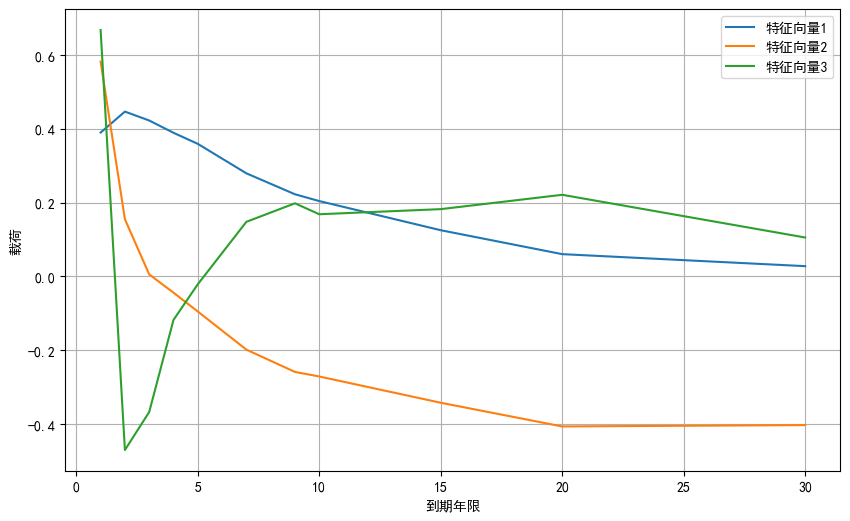

In [39]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

# 原始数据 (月 VaR, 单位: %)
maturities = [1, 2, 3, 4, 5, 7, 9, 10, 15, 20, 30]
price_var = [0.470, 0.987, 1.484, 1.971, 2.426, 3.192, 3.913, 4.250, 6.234, 8.146, 11.119]  # 债券价格 VaR
yield_var = [5.83, 5.71, 5.81, 5.89, 5.96, 6.07, 6.20, 6.26, 6.59, 6.74, 6.72]  # 收益率 VaR
adjusted_var = [0.945, 1.892, 2.835, 3.777, 4.719, 6.599, 8.475, 9.411, 14.072, 18.737, 28.111]  # 修正 VaR
adjusted_var_ratio = [0.497, 0.522, 0.523, 0.522, 0.514, 0.484, 0.462, 0.452, 0.443, 0.435, 0.396]  # 修正 VaR 比例

# 置信水平 (95%)
z_score = 1.65

# 计算基于 adjusted_var_ratio 的月标准差和方差
adjusted_var_ratio_std = np.array(adjusted_var_ratio) / z_score /100   # 转换为小数
# adjusted_variances = adjusted_var_ratio_std ** 2  # 月方差, 单位: %²
annual_std_devs = np.round(adjusted_var_ratio_std * np.sqrt(12),4)
print("年化标准差 (%):", np.round(annual_std_devs * 100, 4))

# 相关矩阵
n = len(maturities)
corr_matrix = np.zeros((n, n))
data_rows = [
    [1.0], 
    [0.897, 1.0], 
    [0.866, 0.991, 1.0], 
    [0.866, 0.976, 0.994, 1.0],
    [0.855, 0.966, 0.988, 0.988, 1.0], 
    [0.825, 0.936, 0.965, 0.982, 0.990, 1.0],
    [0.796, 0.909, 0.942, 0.964, 0.975, 0.996, 1.0],
    [0.788, 0.903, 0.937, 0.959, 0.971, 0.994, 0.999, 1.0],
    [0.740, 0.853, 0.891, 0.915, 0.930, 0.961, 0.976, 0.981, 1.0],
    [0.679, 0.791, 0.832, 0.860, 0.878, 0.919, 0.942, 0.951, 0.991, 1.0],
    [0.644, 0.761, 0.801, 0.831, 0.853, 0.902, 0.931, 0.943, 0.975, 0.981, 1.0]
]
for i in range(n):
    for j in range(i + 1):
        corr_matrix[i, j] = data_rows[i][j]
corr_matrix = corr_matrix + corr_matrix.T - np.diag(np.diag(corr_matrix))

# 构造协方差矩阵
cov_matrix = np.outer(adjusted_var_ratio_std, adjusted_var_ratio_std) * corr_matrix

# PCA 分析
pca = PCA()
pca.fit(cov_matrix)
explained_variance = pca.explained_variance_  # 单位: %²
explained_variance_ratio = pca.explained_variance_ratio_  # 比例
components = pca.components_  # 载荷




# 创建 DataFrame 输出主成分载荷
loadings_data = {
    '到期年限 (年)': maturities,
    '特征向量1': np.round(components[0], 3),
    '特征向量2': np.round(components[1], 3),
    '特征向量3': np.round(components[2], 3)
}
loadings_df = pd.DataFrame(loadings_data)
display(loadings_df.set_index('到期年限 (年)'))

# 可视化载荷
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot(maturities, components[i], label=f'特征向量{i+1}')
plt.xlabel('到期年限')
plt.ylabel('载荷')
# plt.title('PCA Loadings for U.S. Treasury Yields (Monthly, Adjusted VaR Ratio)')
plt.legend()
plt.grid(True)
plt.show()

: 